# Gradcam with Transfer Learning

This is a simple example to show how Gradcam could be used with models that used transfer learning techniques.
The first part of setting up and building the model is just an example and it can be setting up in other ways. The important thing here is apply transfer learning and than use Gradcam on it.

### Setting up 

In [1]:
from gradcam import Gradcam

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0

In [2]:
size = 224
img_size=(size, size)
img_shape = (size, size, 3)
batch_size = 32

### Loading Dataset

In [3]:
tfds.disable_progress_bar()

train_ds, validation_ds, test_ds = tfds.load(
    "cats_vs_dogs",
    split=[
       tfds.Split.TRAIN.subsplit(tfds.percent[:10]),
       tfds.Split.TRAIN.subsplit(tfds.percent[10:13]),
       tfds.Split.TRAIN.subsplit(tfds.percent[13:16])
    ],
    as_supervised=True,  # Include labels
)

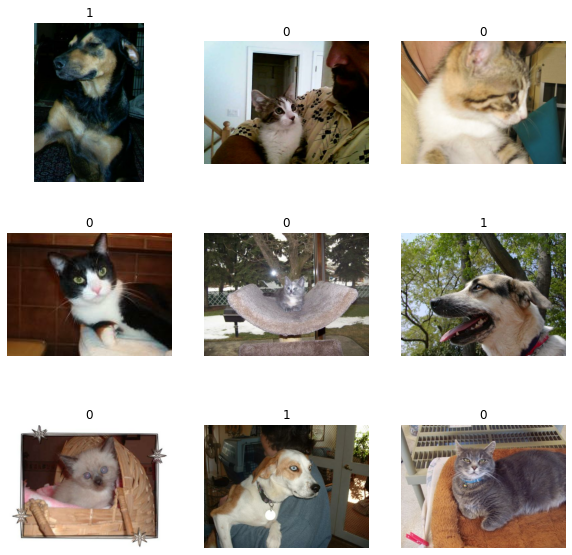

In [4]:
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")

In [5]:
train_ds = train_ds.map(lambda image, label: (tf.image.resize(image, img_size), label))
validation_ds = validation_ds.map(lambda image, label: (tf.image.resize(image, img_size), label))

train_ds = train_ds.cache().batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
validation_ds = validation_ds.cache().batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

In [6]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

### Building Model

In [7]:
def build_model(base_model):
    inputs = layers.Input(shape=img_shape)
    x = data_augmentation(inputs)
    x = base_model(x, training=False)

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(x)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.4
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(2, activation="softmax", name="pred")(x)

    model = tf.keras.Model(inputs, outputs, name="EfficientNetB0")

    return model

base_model = EfficientNetB0(include_top=False, input_shape=img_shape, weights="imagenet")
base_model.trainable = False
model = build_model(base_model)

# Compile
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
loss = keras.losses.SparseCategoricalCrossentropy()
metrics = keras.metrics.SparseCategoricalAccuracy()
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=[metrics]
)

model.summary()

Model: "EfficientNetB0"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
avg_pool (GlobalAveragePooli (None, 1280)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1280)              5120      
_________________________________________________________________
top_dropout (Dropout)        (None, 1280)              0         
_________________________________________________________________
pred (Dense)                 (None, 2)              

In [8]:
model.fit(train_ds, epochs=5, validation_data=validation_ds)

Epoch 1/5
73/73 [==============================] - 111s 2s/step - loss: 0.2868 - sparse_categorical_accuracy: 0.9524 - val_loss: 0.0372 - val_sparse_categorical_accuracy: 0.9900
Epoch 2/5
73/73 [==============================] - 103s 1s/step - loss: 0.1895 - sparse_categorical_accuracy: 0.9708 - val_loss: 0.0995 - val_sparse_categorical_accuracy: 0.9828
Epoch 3/5
73/73 [==============================] - 105s 1s/step - loss: 0.2382 - sparse_categorical_accuracy: 0.9730 - val_loss: 0.0823 - val_sparse_categorical_accuracy: 0.9900
Epoch 4/5
73/73 [==============================] - 103s 1s/step - loss: 0.1982 - sparse_categorical_accuracy: 0.9742 - val_loss: 0.1228 - val_sparse_categorical_accuracy: 0.9928
Epoch 5/5
73/73 [==============================] - 106s 1s/step - loss: 0.2075 - sparse_categorical_accuracy: 0.9768 - val_loss: 0.1487 - val_sparse_categorical_accuracy: 0.9900


### Gradcam

In [10]:
%matplotlib agg
%matplotlib agg

img_path = "../images/example.jpg"

gc = Gradcam(model, 
             layer_name="top_conv",
             img_path=img_path,
             size=img_size,
             inner_model=model.get_layer("efficientnetb0"))

gc.generate_stack_img(save_name="../output/example_out")

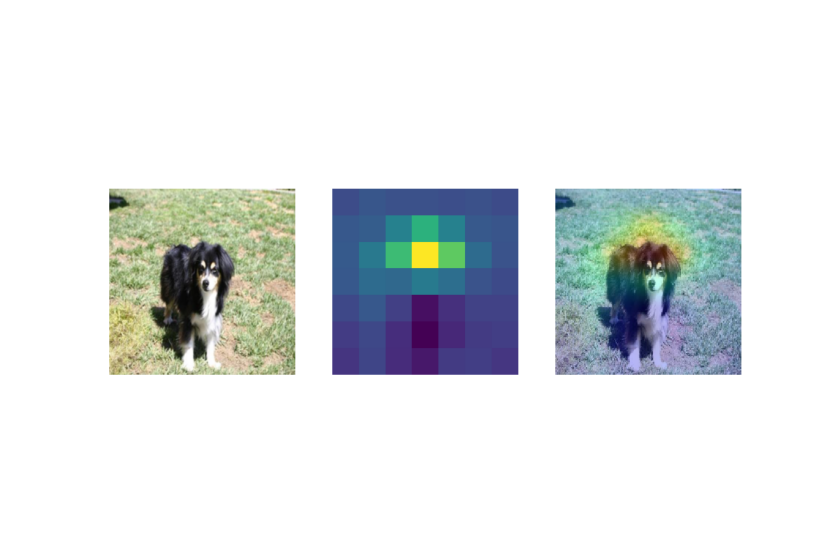

In [11]:
%matplotlib inline

output = mpimg.imread('../output/example_out.png')
fig, ax = plt.subplots(figsize=(15,10))
plt.axis("off")
plt.imshow(output)